In [5]:
import numpy as np
import imageio
from typing import Tuple
from mip.display.image import show, read, subplot_images
import matplotlib.pyplot as plt
from scipy.ndimage import convolve  
from scipy.signal import convolve2d

from mip.src.tykhonov_regularization import grad, div

In [2]:
def createGaussianBlurringOperator(size_I, hsize, sigma):
    """
    Creates an operator for blurring with a Gaussian kernel of size 'hsize' and standard deviation 'sigma'.
    
    Parameters:
    size_I (tuple): Size of the image (height, width).
    hsize (int): Size of the Gaussian kernel.
    sigma (float): Standard deviation of the Gaussian kernel.
    
    Returns:
    Op (function): Blurring operator.
    Op_adj (function): Adjoint of the blurring operator.
    fftFilter (numpy.ndarray): FFT of the Gaussian kernel.
    """
    # Create Gaussian kernel
    kernel = np.outer(
        np.exp(-np.linspace(-(hsize//2), hsize//2, hsize)**2 / (2*sigma**2)),
        np.exp(-np.linspace(-(hsize//2), hsize//2, hsize)**2 / (2*sigma**2))
    )
    kernel /= np.sum(kernel)
    
    # Initialize FFT filter with zeros and place the kernel in the top-left corner
    fftFilter = np.zeros(size_I)
    fftFilter[:kernel.shape[0], :kernel.shape[1]] = kernel
    
    # Center the kernel
    fftFilter = np.roll(fftFilter, -kernel.shape[0]//2 + 1, axis=0)
    fftFilter = np.roll(fftFilter, -kernel.shape[1]//2 + 1, axis=1)
    
    # Compute the FFT of the kernel and its conjugate
    fftFilter = np.fft.fftn(fftFilter)
    fftFilterC = np.conj(fftFilter)
    
    # Define the operators
    Op = lambda x: np.fft.ifftn(np.fft.fftn(x) * fftFilter).real
    Op_adj = lambda y: np.fft.ifftn(np.fft.fftn(y) * fftFilterC).real
    
    return Op, Op_adj, fftFilter

## van-Cittert Iterations

In [9]:
def deconv_van_cittert(f: np.ndarray, k_A: np.ndarray, iterations: int):
    titles = []
    images = []
    u = f.copy()
    q = 1 - k_A
    for i in range(iterations):
        u = f + np.fft.ifft2(np.fft.fft2(u) * q).real
        if (i+1) % 3 == 0:
            titles.append(f"Deconvolved at iteration: {i+1}")
            images.append(u)
    return titles, images

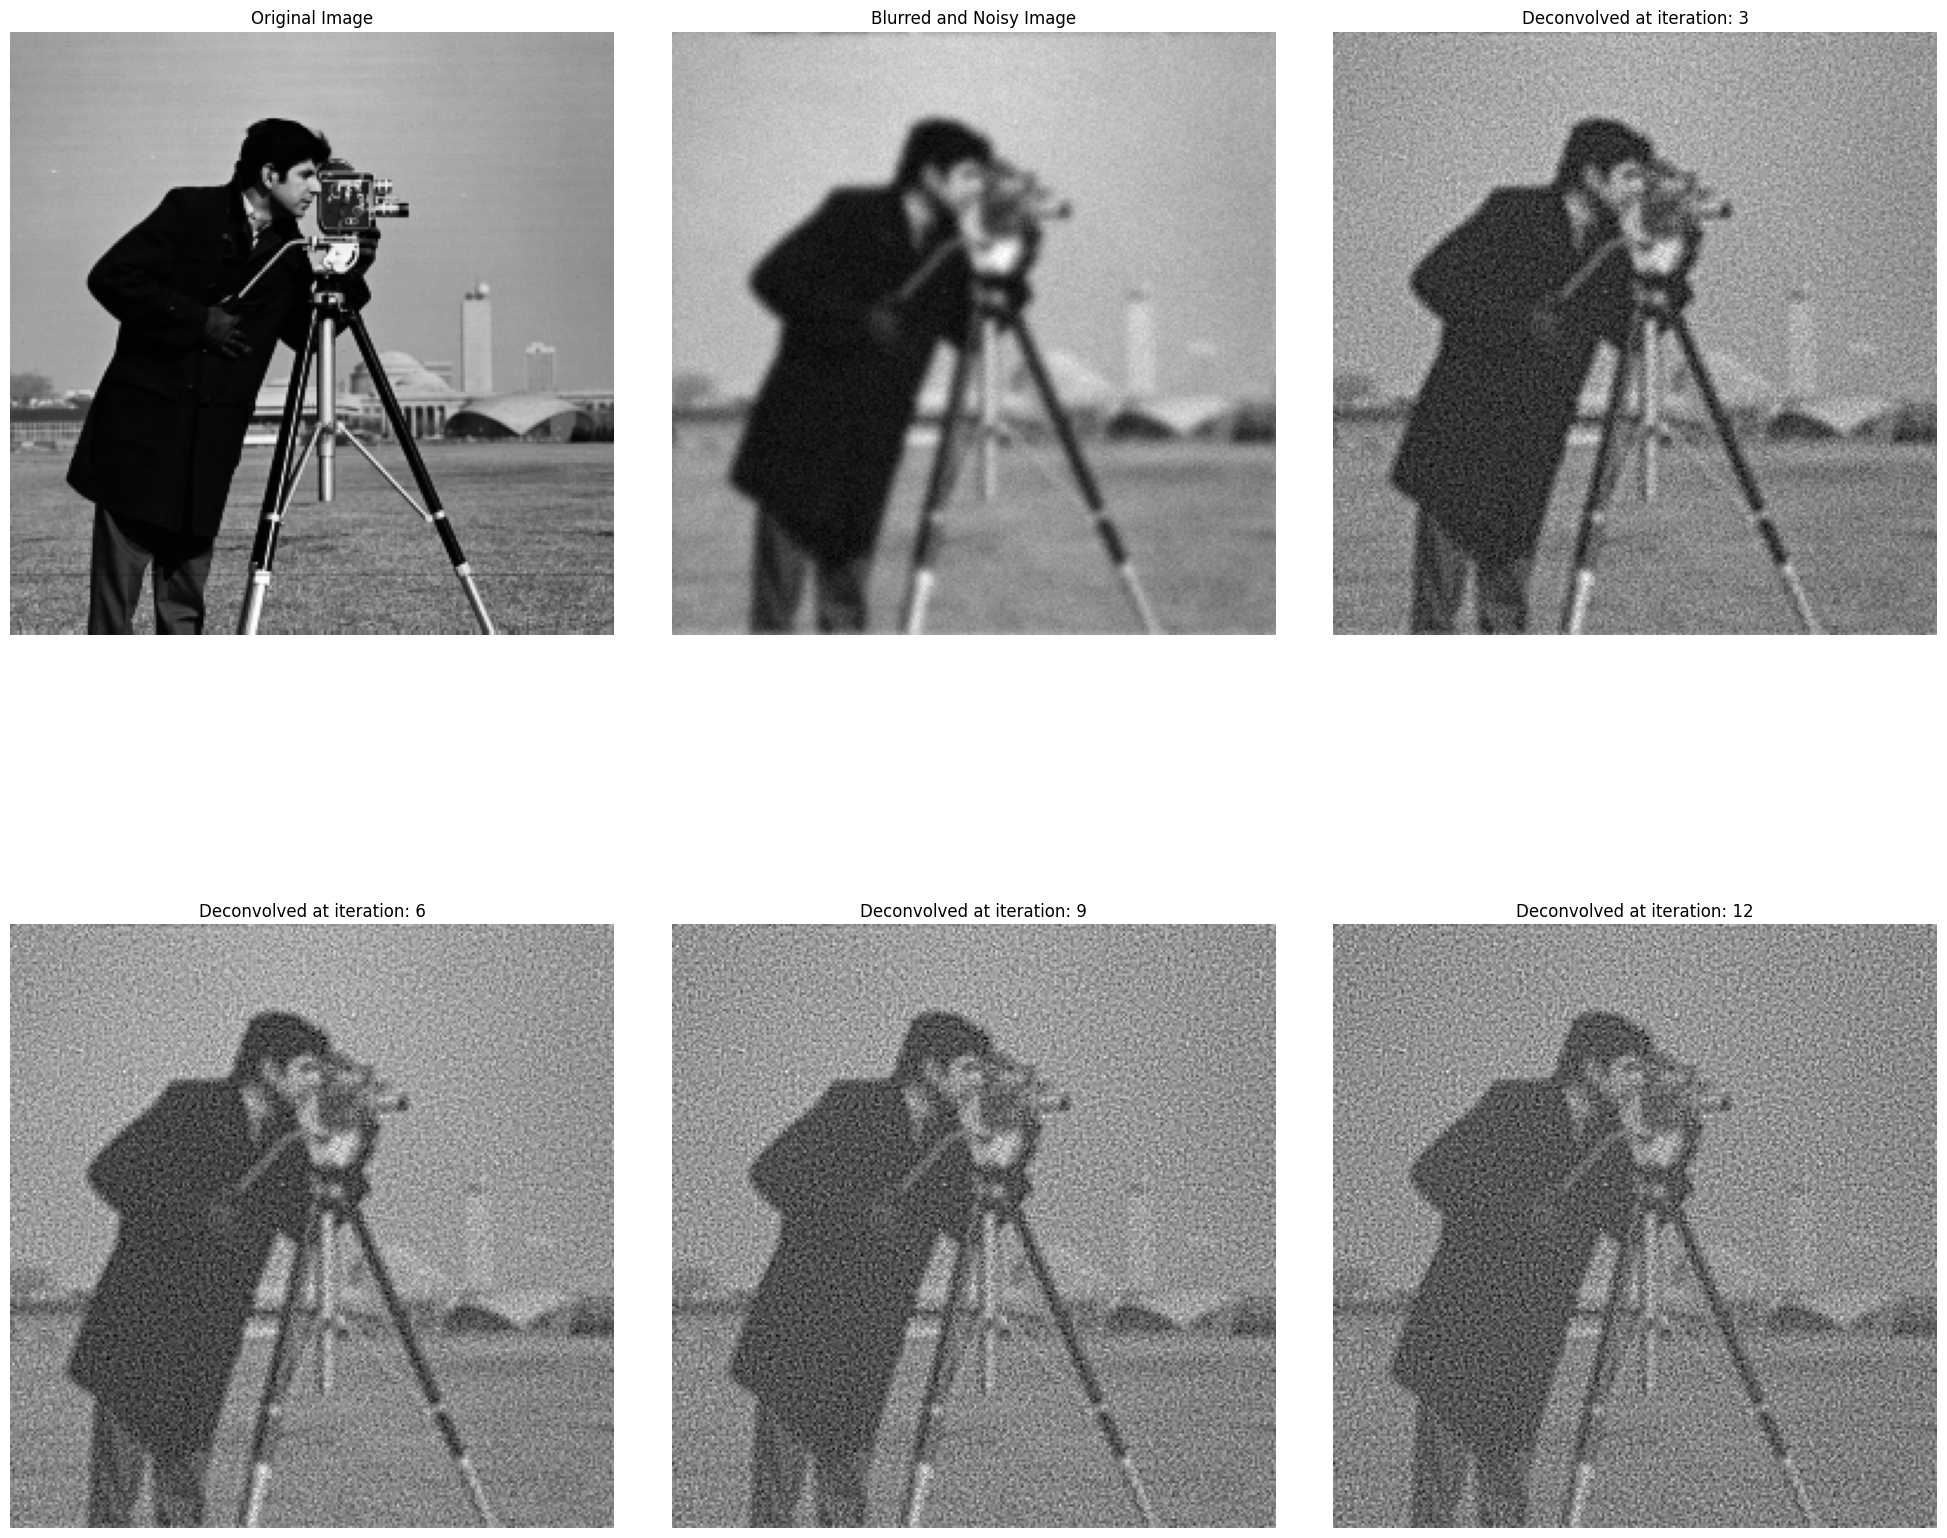

In [10]:
I = read("../assets/cameraman.png", "GRAY")
I = I.astype(np.float64)

k = 5
gamma = 2 * k + 1 # size of kernel
sigma = 2
iterations = 15

# Blurring and adding noise
Op, Op_adj, kA = createGaussianBlurringOperator(I.shape, gamma, sigma)
I_nse = Op(I) + 5 * np.random.randn(*I.shape)

# Deconvolution
titles, images = deconv_van_cittert(I_nse, kA, iterations)

images.insert(0, I)
images.insert(1, I_nse)
titles.insert(0, "Original Image")
titles.insert(1, "Blurred and Noisy Image")

subplot_images(
    images, titles=titles, fig_size=(20, 18), order=(-1, 3), dpi=100
).savefig("../exercise_solutions/ex4/deconv_vanCittert.png")

plt.show()

## TV-regularized deconvolution

Solving the deconvolution problem using the primal-dual algorithm, we need to minimize the following objective functions:

$
    u^* = arg min
$

In [17]:
def apply_A(x, A):
    return convolve2d(x, A, mode="same")


def apply_At(x, A):
    return convolve2d(x, A[::-1, ::-1], mode="same")


def deconv_TV_pd(f: np.ndarray, A: np.ndarray, _lambda: float, iterations: int):
    images = []
    titles = []
    energies = []

    tau = 0.1
    sigma = 0.01
    theta = 1

    u = f.copy()
    u_bar = u.copy()
    p = grad(u)
    q = div(p)

    for i in range(iterations):
        # dual update for p
        grad_u_bar = grad(u_bar)
        p = (p + sigma * grad_u_bar) / np.maximum(
            1, np.linalg.norm(p + sigma * grad_u_bar, axis=2, keepdims=True)
        )

        # dual update for q
        q = (q + sigma * (apply_A(u_bar, A) - f)) / (1 + sigma * _lambda)

        # primal update for u
        u_new = u - tau * (div(p) + apply_At(q, A))

        # over-relaxation
        u_bar = u_new + theta * (u_new - u)

        # update u
        u = u_new

        # compute the energy
        energy = 0.5 * np.linalg.norm(apply_A(u, A) - f) ** 2 + _lambda * np.sum(
            np.abs(grad(u))
        )
        energies.append(energy)

        if (i + 1) % 3 == 0:
            titles.append(f"Deconvolved at iteration: {i+1}")
            images.append(u.copy())
            energies.append(energy)

    return titles, images, energies

TypeError: Image data of dtype complex128 cannot be converted to float

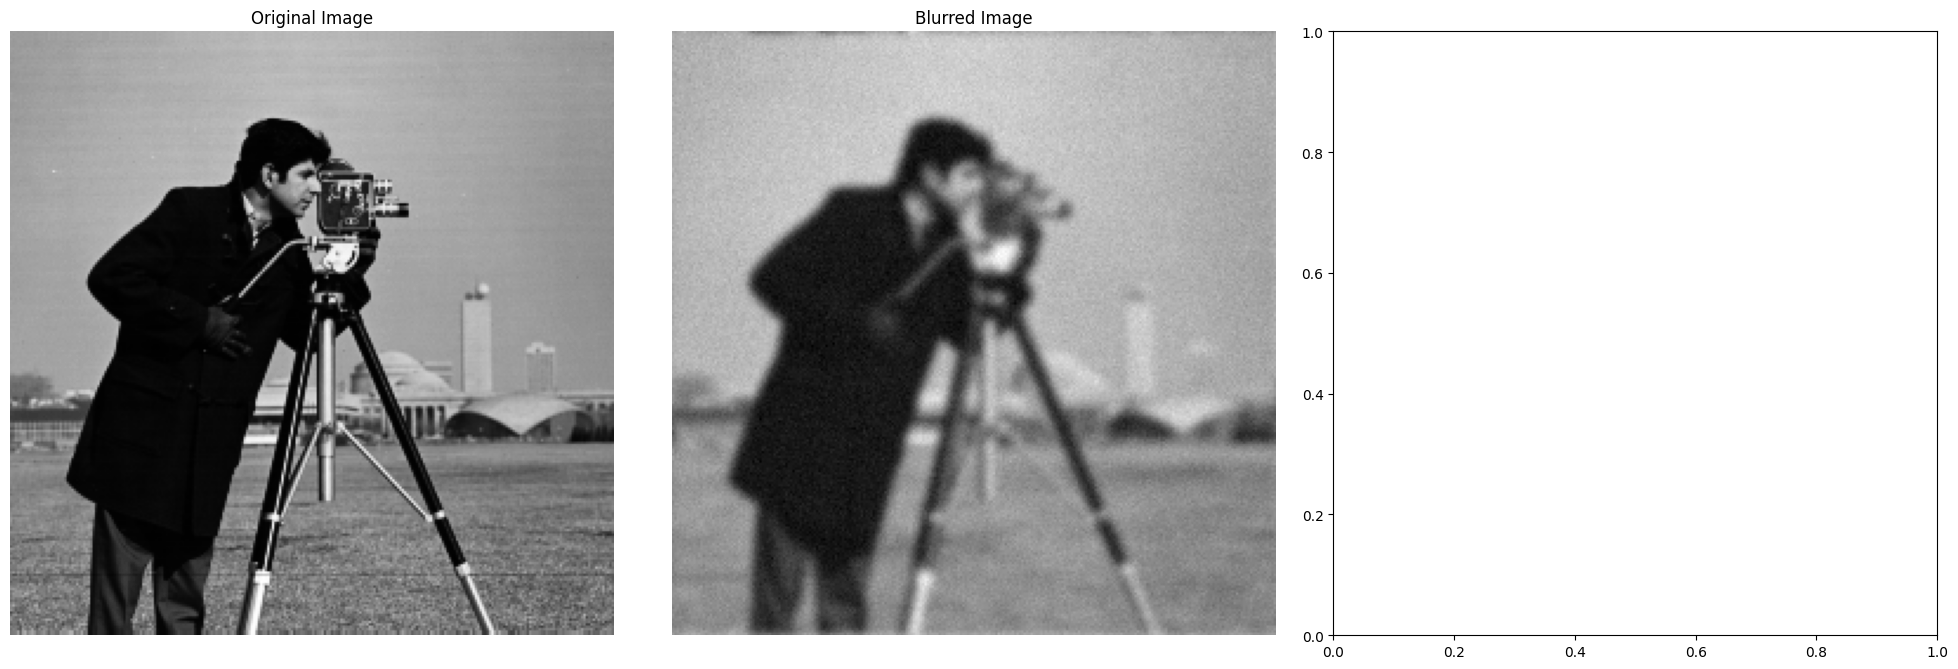

In [19]:
_lambda_ = 0.1
_iterations = 10
k = 5
gamma = 2 * k + 1 # size of kernel
sigma = 2


I = read("../assets/cameraman.png", "GRAY")
I = I.astype(np.float64)


# Blurring and adding noise
Op, Op_adj, kA = createGaussianBlurringOperator(I.shape, gamma, sigma)
I_nse = Op(I) + 5 * np.random.randn(*I.shape)

titles, images, energies = deconv_TV_pd(I_nse,kA, _lambda_, _iterations)

# Take the real part of the images
images = [np.real(img) for img in images]

# Add original and blurred images to the list
images.insert(0, I)
titles.insert(0, "Original Image")
images.insert(1, I_nse)
titles.insert(1, "Blurred Image")

subplot_images(
    images, titles=titles, fig_size=(20, 18), order=(-1, 3), dpi=100
).savefig("../exercise_solutions/ex4/primal_dual_deconv.png")

plt.show()

